In [1]:
"""
Note: I didn't want to include the model weights to github bc of its size, 
so you might need to download them yourself

path in savio:
/global/scratch/tlu2000/dev/models/

it was saved to ../models/ when I ran it
""";

In [2]:
import sys
sys.path.append("../src")
import torch
from benepar import decode_chart
from benepar import nkutil
from benepar import parse_chart
from tree_transforms import collapse_unlabel_binarize
from treebanks import ParsingExample, Treebank
import numpy as np
from nltk.tree import Tree

In [3]:
class IParser():
    def __init__(self, model_path_base):
#         self.info = torch.load(model_path_base, map_location=lambda storage, location: storage)
        self.parser = parse_chart.ChartParser.from_trained(model_path_base)
    
    def remove_pos(self, tree):
        """
        mutates tree to remove the POS that has to be added
        """
        if isinstance(tree, str) or len(tree) < 1:
            return
        for i in range(len(tree)):
            if isinstance(tree[i], str):
                continue
            elif tree[i].label() == 'UNK':
                tree[i] = tree[i][0]
            else:
                self.remove_pos(tree[i])
    
    def parse_sentence(self, sent):
        words = sent.split()
        treebank = Treebank([
            ParsingExample(tree=None, words=words, space_after=[True for w in words],\
                           _pos=[(w, 'UNK') for w in words])
        ])
        tree, cats = self.parser.parse(treebank, return_cats=True, tau=0)[0]
        self.remove_pos(tree)
        return tree, cats
    
    def tree_from_cats(self, cats, words='cat'):
        tree = self.parser.parse([cats], tau=0)[0]
        self.remove_pos(tree)
        return tree

In [4]:
iparse = IParser("../models/gpn_2label_d2_gpt2_7509601_dev=91.39.pt")

gpt2


Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[0 1 1 0 1 0 1 1 0 0 0]


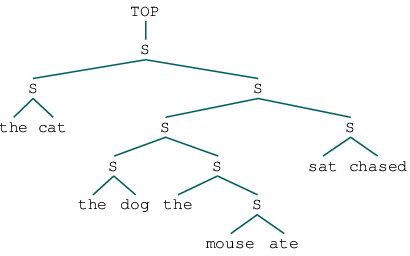

In [5]:
tree2, cats = iparse.parse_sentence("the cat the dog the mouse ate sat chased")
print(cats)
display(tree2)

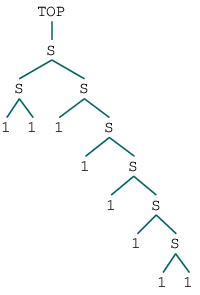

In [31]:
iparse.tree_from_cats([0, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [ ]:
# iparse.tree_from_cats(categories)

In [ ]:
# needs to be relative positiona

def tree_diff_node(tree1, tree2, num_prev=2):
    """
    returns the part of the tree where a change occured. 
    """
    diff = [tree1, tree2]
    while True:
        tree1, tree2 = diff
        if tree1 == tree2:
            return "no change"
        if len(tree1) != len(tree2):
            return tree1, tree2
        diff = []
        for sub1, sub2 in zip(tree1, tree2):
            if sub1 != sub2:
                if not diff:
                    diff = [sub1, sub2]
                else:
                    return tree1, tree2

                
# do things like in same tree, left branch, etc
def to_top(tree2):
    # check if new token is a child of root, but second to last wasn't
    tree2_top = tree2[-1][0] == tree2.leaves()[-1]
    tree1_not_top = tree2[-2][0] != tree2.leaves()[-2]
    return tree1_not_top and tree2_top

def sister(tree2):
    # use tree_diff_node, second tree follows /\
    leaves = tree2.leaves()
    t2 = tree2[tree2.treeposition_spanning_leaves(len(leaves)-2, len(leaves))]
#     display(t2)
    return len(t2) > 1 and t2[-2][0] == leaves[-2] and t2[-1][0] == leaves[-1]

def aunt(tree2):
    # new token c-commands old
    # use tree_diff_node, new token child of root, but not old
    leaves = tree2.leaves()
    t2 = tree2[tree2.treeposition_spanning_leaves(len(leaves)-2, len(leaves))]
#     display(t2)
    return len(t2) > 1 and type(t2[-2][-1])==Tree and  t2[-2][-1] != leaves[-2] and t2[-1][0] == leaves[-1]



In [ ]:
tree1, categories1 = iparse.parse_sentence('I wanted to eat')
display(tree1)
tree2, categories2 = iparse.parse_sentence('I wanted to eat and')
display(tree2)
print('top', to_top(tree2))
print('sis', sister(tree2))
print('aunt', aunt(tree2))

In [ ]:
tree1, categories1 = iparse.parse_sentence('I have one ')
display(tree1)
tree2, categories2 = iparse.parse_sentence('I have one cat')
display(tree2)
print('top', to_top(tree2))
print('sis', sister(tree2))
print('aunt', aunt(tree2))

In [ ]:
tree1, categories1 = iparse.parse_sentence('I thought I ate ')
display(tree1)
tree2, categories2 = iparse.parse_sentence('I thought I ate him.')
display(tree2)
print('top', to_top(tree2))
print('sis', sister(tree2))
print('aunt', aunt(tree2))

In [ ]:
from collections import defaultdict

def make_stat_dict(cats):
    stat_dict = {'top': defaultdict(int), 'sis': defaultdict(int), 'aunt': defaultdict(int), 'n':defaultdict(int)}

    for cat in cats:
        tree = iparse.tree_from_cats(cat, words='idx')
        last2 = tuple(cat[-3:-1])
        stat_dict['n'][last2] += 1
        for label, func in [['top', to_top], ['sis', sister], ['aunt', aunt]]:
            if func(tree):
                stat_dict[label][last2] += 1

    return stat_dict

def num2list(i, cats=4, sen_len=4):
    curr = []
    for _ in range(sen_len):
        curr.append(i % cats)
        i //= cats
    return curr

def print_proportions(cats, num_cats=4):
    stat_dict = make_stat_dict(cats)
    print("proportions of each class")
    for label, d in stat_dict.items():
        if label != 'n':
            print(label, sum(d.values()) / sum(stat_dict['n'].values()))
    print("_"*50, '\n')
    
    print("as last key")
    for i in range(num_cats):
        print('Key: ', i)
        for label, d in stat_dict.items():
            if label != 'n':
                a = 0
                n = 0
                for j in range(num_cats):
                    a += d[(j, i)]
                    n += stat_dict['n'][(j, i)]
                if n > 0:
                    print(label, a / n, '\n')
    print("_"*50, '\n')
    
    print("as second to last key")
    for i in range(num_cats):
        print('Key: ', i)
        for label, d in stat_dict.items():
            if label != 'n':
                a = 0
                n = 0
                for j in range(num_cats):
                    a += d[(i,j)]
                    n += stat_dict['n'][(i,j)]
                if n > 0:
                    print(label, a / n, '\n')
    print("_"*50, '\n')
    for key in stat_dict['n'].keys():
        print("Key: ", key)
        for label, d in stat_dict.items():
            if label != 'n':
                print(label, d[key] / stat_dict['n'][key], '\n')
        print('='*50, '\n')

In [ ]:
def make_gen(num_words, num_cats=4):
    for i in range(num_cats**num_words):
        yield [1] + num2list(i, cats=num_cats, sen_len=num_words) + [0]
        
print('2 words')
print_proportions(make_gen(2, num_cats=4))

In [ ]:
print('3 words')
print_proportions(make_gen(3, num_cats=4))

In [ ]:
print('4 words')
print_proportions(make_gen(4, num_cats=4))

In [ ]:
print('5 words')
print_proportions(make_gen(5, num_cats=4))

In [ ]:
print('6 words')
print_proportions(make_gen(6, num_cats=4))

In [ ]:
print('7 words')
print_proportions(make_gen(7, num_cats=4))